<a href="https://www.kaggle.com/code/sumaiyakawsar/yoga-pose-classification-using-vgg16?scriptVersionId=212405194" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Yoga Pose Classification Using VGG16
This notebook demonstrates how to classify yoga poses using transfer learning with the VGG16 model. We'll cover data preprocessing, model creation, training, and evaluation while adhering to good coding practices.

### Key Features

* Used VGG16 pre-trained model for feature extraction.
* Implemented data augmentation for better generalization.
* Achieved high accuracy using transfer learning with minimal fine-tuning.
* Visualized training and validation curves for performance insights.


## Step 1: Import Libraries

In [1]:
# Import Data Science Libraries
import numpy as np
import tensorflow as tf
import os
import warnings

# Import visualization libraries
import matplotlib.pyplot as plt

# Tensorflow Libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import plot_model
# Callbacks
from keras.callbacks import Callback, ReduceLROnPlateau
# LR Scheduler
from keras.optimizers import Adam
from PIL import Image, ImageFile

# %matplotlib inline
warnings.filterwarnings('ignore')
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Step Bonus: Define Reusable Functions

To streamline the process, reusable functions for generating paths and plotting metrics are defined:

In [2]:
def image_path(image_name):
    """Returns the full path of an image given its name."""
    return os.path.join(images_dir, image_name)

def model_path(model_name):
    """Returns the full path of a model given its name."""
    return os.path.join(model_dir, model_name)
    
def plot_metric(history):
    """Plots training and validation accuracy/loss curves."""
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_accuracy) + 1)
    
    # Plot accuracy
    plt.plot(epochs, train_accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    # plt.savefig(image_path("Training and validation accuracy.png"))

    # Plot loss
    plt.figure()
    plt.plot(epochs, train_loss,label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.legend(["train_loss", 'val_loss'])

    #Save image
    # plt.savefig(image_path("Training and validation loss.png"))
    plt.show()

## Step 2: Data Preprocessing

### 2.1 Set Up Directories

In [3]:
# Setting the path to the training directory that contains the data for yoga asanas
train_dir = '/kaggle/input/yoga-poses-dataset/DATASET/TRAIN'

# Setting the path to the test directory that contains the data for yoga asanas
test_dir = '/kaggle/input/yoga-poses-dataset/DATASET/TEST'

# Setting the path to the directory containing images for the assignment
images_dir = '/kaggle/working/Images'

# Setting the path to the directory where the trained models will be saved
model_dir = '/kaggle/working/Models'

In [4]:
#  list all the files in the directory and store them in 'class_names' alphabetically
class_names = sorted(os.listdir(train_dir))
# number of classes present
no_classes = len(class_names)

print(f"Classes :{class_names}")
print(f"Total Number of Classes : {no_classes}")

Classes :['downdog', 'goddess', 'plank', 'tree', 'warrior2']
Total Number of Classes : 5


In [5]:
class_dis_tr = [len(os.listdir(train_dir + f"/{name}")) for name in class_names]
print(class_dis_tr)

class_dis_te = [len(os.listdir(test_dir + f"/{name}")) for name in class_names]
print(class_dis_te)

[223, 180, 266, 160, 252]
[97, 80, 115, 69, 109]


### 2.2 Initialize Data

In [6]:
# Set the batch size for training
batch_size=16

# Set the number of epochs
EPOCHS = 22

### 2.3 Data augmentation

In [7]:
# Define the training data generator with specified augmentations
train_datagen = IDG(shear_range=0.2,      # Randomly apply shearing transformations
                    zoom_range=0.2,       # Randomly zoom inside images
                    horizontal_flip=True, # Randomly flip images horizontally
                    rescale = 1./255      # Rescale the pixel values to [0,1]
                    )

# Define the testing data generator with rescaling only
test_datagen = IDG(rescale = 1./255 )     # Rescale the pixel values to [0,1]

In [8]:
# Create a generator for training data from a directory
train_generator =  train_datagen.flow_from_directory(train_dir,                 # Directory path for training data
                                                    target_size = (224,224),    # Reshape images to the specified dimensions
                                                    color_mode = 'rgb',         # Color mode set to RGB
                                                    class_mode = 'categorical', # Use categorical labels
                                                    batch_size = batch_size     # Set the batch size for training
                                                     )

# Create a generator for validation data from a directory
validation_generator  = test_datagen.flow_from_directory(test_dir,              # Directory path for testing data
                                                  target_size = (224,224),
                                                  color_mode = 'rgb',
                                                  class_mode = 'categorical'
                                                 )

Found 1081 images belonging to 5 classes.
Found 470 images belonging to 5 classes.


In [9]:
print("number of images", train_generator.samples)
print("number of class", len(train_generator.class_indices))
print("number of images in the classes", train_generator.samples / len(train_generator.class_indices))

print("number of images", validation_generator.samples)
print("number of class", len(validation_generator.class_indices))
print("number of images in the classes", validation_generator.samples / len(validation_generator.class_indices))

number of images 1081
number of class 5
number of images in the classes 216.2
number of images 470
number of class 5
number of images in the classes 94.0


## Step 3: Model Creation

### 3.1 Model Creation

In [10]:
# Model Name
model_name = "Yoga-Pose-Classification"

In [11]:
# Load VGG16 pre-trained model
vgg16 = VGG16(include_top=False,
              weights='imagenet',
              input_shape=(224,224,3),
              pooling=None)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Set all layers in the VGG16 model to be non-trainable
for layer in vgg16.layers:
    layer.trainable = False

In [13]:
# Define a function to create the baseline model
def create_baseline():

    # Instantiate the sequential model and add the VGG16 model:
    model_vgg = Sequential(name=model_name+"_VGG")
    model_vgg.add(vgg16)

    # Add the custom layers atop the VGG19 model:
    model_vgg.add(Flatten(name='flattened'))                                    # Flattens the input without affecting the batch size
    model_vgg.add(Dropout(0.5, name='dropout1'))                                # Apply dropout to prevent overfitting
    model_vgg.add(Dense(256, activation='relu'))                                # Add a fully connected layer with ReLU activation
    model_vgg.add(Dropout(0.2, name='dropout2'))                                # Apply another dropout
    model_vgg.add(Dense(no_classes, activation='softmax', name='predictions'))  # Add the output layer with softmax activation

    return model_vgg

In [14]:
# Create the VGG16-based model
model_vgg = create_baseline()

In [15]:
# Display a summary of the model architecture
model_vgg.summary()

Model: "Yoga-Pose-Classification_VGG"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flattened (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
model_vgg.build()

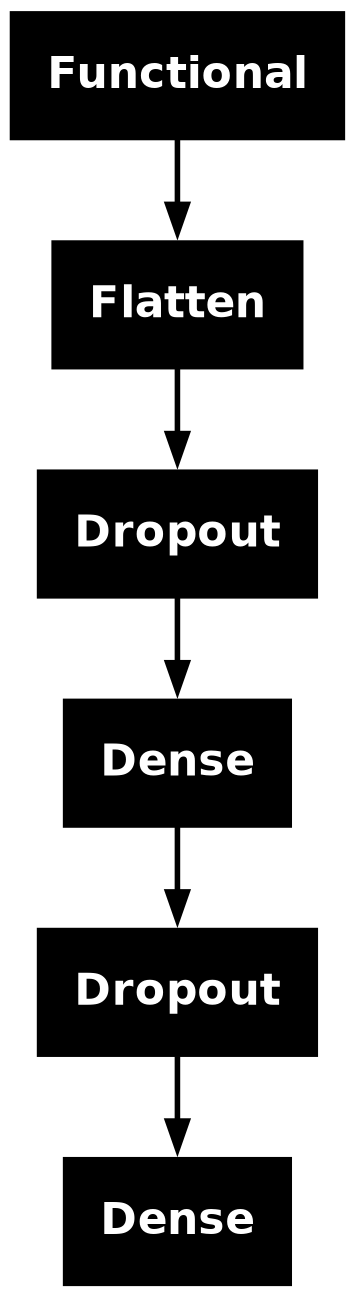

In [17]:
# Plot the model architecture and save it to an image file
plot_model(model_vgg)
# Plot the model architecture and save it to an image file
# plot_model(model_vgg, to_file=image_path(model_name+"_vgg.png"))

## Step 4: Compile Model

In [18]:
# Compile the model with specified loss function, optimizer, and metrics
model_vgg.compile(
    loss='categorical_crossentropy',# Categorical cross-entropy loss for multi-class classification
    optimizer=Adam(0.001),          # Adam optimizer with a learning rate of 0.001
    metrics=["accuracy"]            # Monitor the accuracy metric during training
)

## Step 5: Define Callbacks

In [19]:
# Create a ReduceLROnPlateau callback with the following parameters:
# This callback monitors the validation accuracy and adjusts the learning rate when the validation accuracy plateaus
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',    # Monitors the validation accuracy to decide when to reduce the learning rate.
                                            patience=3,     # Number of epochs with no improvement after which learning rate will be reduced
                                            verbose=1,      # Verbosity level. 1 for updating messages, 0 for silence.
                                            factor=0.5,     # Learning rate will be reduced to half. New_lr = lr * factor
                                            min_lr=0.00001  # Lower bound on the learning rate. It won't reduce the learning rate below this value
                                 )

In [20]:
# Store the ReduceLROnPlateau callback in a list. This list can be passed to a training session.
cbs = [lr_reduction]

## Step 6: Train the Model

In [21]:
history = model_vgg.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=EPOCHS,
                    batch_size=batch_size,
                    callbacks=cbs,
                    shuffle=True)

Epoch 1/22


I0000 00:00:1733881984.096996      80 service.cc:145] XLA service 0x7be0e0004660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733881984.097071      80 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733881984.097079      80 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/68 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.1250 - loss: 2.2061  

I0000 00:00:1733881995.689843      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


68/68 ━━━━━━━━━━━━━━━━━━━━ 81s 971ms/step - accuracy: 0.4711 - loss: 2.2019 - val_accuracy: 0.9191 - val_loss: 0.2721 - learning_rate: 0.0010
Epoch 2/22
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 402ms/step - accuracy: 0.8117 - loss: 0.5581 - val_accuracy: 0.9596 - val_loss: 0.1437 - learning_rate: 0.0010
Epoch 3/22
68/68 ━━━━━━━━━━━━━━━━━━━━ 29s 389ms/step - accuracy: 0.8801 - loss: 0.3762 - val_accuracy: 0.9638 - val_loss: 0.1412 - learning_rate: 0.0010
Epoch 4/22
68/68 ━━━━━━━━━━━━━━━━━━━━ 29s 404ms/step - accuracy: 0.9038 - loss: 0.2840 - val_accuracy: 0.9511 - val_loss: 0.1560 - learning_rate: 0.0010
Epoch 5/22
68/68 ━━━━━━━━━━━━━━━━━━━━ 29s 400ms/step - accuracy: 0.8989 - loss: 0.2991 - val_accuracy: 0.9596 - val_loss: 0.1274 - learning_rate: 0.0010
Epoch 6/22
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 412ms/step - accuracy: 0.9376 - loss: 0.1970 - val_accuracy: 0.9660 - val_loss: 0.1268 - learning_rate: 0.0010
Epoch 7/22
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 414ms/step - accuracy: 0.9057 - loss: 0.2271 - val_

## Step 7: Evaluate: Plot the Graphs

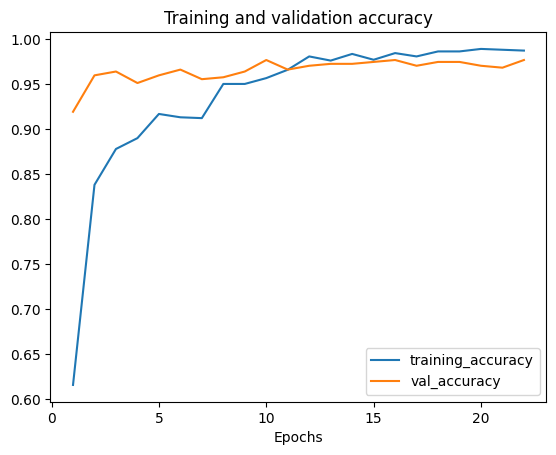

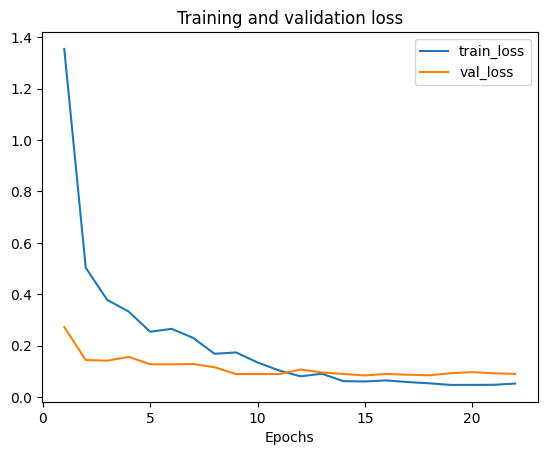

In [22]:
plot_metric(history)
# Save the model to a file
# model_vgg.save(model_path(model_name+'_vgg16.h5'))

In [23]:
train_loss, train_acc = model_vgg.evaluate(train_generator)
test_loss, test_acc   = model_vgg.evaluate(validation_generator)

print(f"Final Train Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {test_acc * 100:.2f}%")

68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 297ms/step - accuracy: 0.9987 - loss: 0.0198
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 548ms/step - accuracy: 0.9771 - loss: 0.0713
Final Train Accuracy: 99.91%
Final Validation Accuracy: 97.66%
